In [11]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import sparse
from scipy.linalg import lu_factor, lu_solve, eigvals
import time

%matplotlib inline


# Лабораторная работа 2 

### Методы решения СЛАУ

- Метод Гаусса с выбором главного элемента

- Метод $LU$-разложение

- Метод Якоби

- Метод Зейделя

- Метод верхней релаксации

- Метод градиентного спуска

- Метод минимальных невязок

- Стабилизированный метод бисопряженных градиентов

### Используемые нормы

#### Норма 1

$
\begin{align}
    ||\boldsymbol{u}||_1 = \max_{1 \leq i \leq n} |\boldsymbol{u}_i|,
\end{align}
$

$
\begin{align}
    ||\boldsymbol{A}||_1 = \max_{1 \leq i \leq n} \sum_{j = 1}^n |a_{ij}|.
\end{align}
$

#### Норма 2

$
\begin{align}
    ||\boldsymbol{u}||_2 = \sum_{j = 1}^n |\boldsymbol{u}_i|,
\end{align}
$

$
\begin{align}
    ||\boldsymbol{A}||_2 = \max_{1 \leq j \leq n} \sum_{i = 1}^n |a_{ij}|.
\end{align}
$

#### Норма 3

$
\begin{align}
    ||\boldsymbol{u}||_3 = \sqrt{(\boldsymbol{u}, \boldsymbol{u})},
\end{align}
$

$
\begin{align}
    ||\boldsymbol{A}||_3 = \sqrt{\max_{1 \leq i \leq n} \lambda_i (\boldsymbol{A^*} \cdot \boldsymbol{A})}.
\end{align}
$
### Решаем СЛАУ (вар. б)
б) $n = 9$, $b_1 = 1$, $c_1 = 0$, $f_1 = 1$, $a_i = c_i = 1$, $b_i = -2$, $p_i = 2$, 
$f_i = \frac{2}{i^2}$, $i = 2, 3, \ldots, n$, $f_{n+1} = -\frac{n}{3}$, $p_1 = p_{n+1} = 1$

$
\begin{align}
\begin{cases}
b_1x_1 + c_1x_2 = f_1 \\
a_2x_1 + b_2x_2 + c_2x_3 = f_2 \\
a_3x_2 + b_3x_3 + c_3x_4 = f_3 \\
\cdots \\
a_nx_{n-1} + b_nx_n + c_nx_{n+1} = f_n \\
p_1x_1 + p_2x_2 + \cdots + p_{n-1}x_{n-1} + p_nx_n + p_{n+1}x_{n+1} = f_{n+1}\\
\end{cases}
\end{align}
$

In [12]:
class Norm:
    def __init__(self, norm, name):
        self.norm = norm
        self.name = name


In [13]:
def norm_1(x):
    return np.linalg.norm(x, ord=np.inf)

def norm_2(x):
    return np.linalg.norm(x, ord=1)

def norm_3(x):
    return np.linalg.norm(x, ord=2)


### Генерация матрицы и вектора правой части

In [19]:
### Генерация матрицы и вектора правой части для варианта б)

n = 9

A = np.zeros((n+1, n+1))
f = np.zeros(n+1)

# Первое уравнение: b₁x₁ + c₁x₂ = f₁
A[0, 0] = 1.0    # b₁ = 1
A[0, 1] = 0.0    # c₁ = 0
f[0] = 1.0       # f₁ = 1

# Уравнения 2 до n: a_ix_{i-1} + b_ix_i + c_ix_{i+1} = f_i
for i in range(1, n):
    A[i, i-1] = 1.0    # a_i = 1
    A[i, i] = -2.0     # b_i = -2
    A[i, i+1] = 1.0    # c_i = 1
    f[i] = 2.0 / ((i+1)**2)  # f_i = 2/i²

# Последнее дополнительное уравнение
for j in range(n+1):
    A[n, j] = 1.0    # p_i = 1 для всех коэффициентов
f[n] = -n / 3.0      # f_{n+1} = -n/3

# Используем правильные названия функций
norms = [Norm(norm_1, "Norm 1"), Norm(norm_2, "Norm 2"), Norm(norm_3, "Norm 3")]


### Метод Гаусса с выбором главного элемента

In [24]:
def swap_rows(A, f, i, j):
    A[[i, j]] = A[[j, i]]
    f[i], f[j] = f[j], f[i]

def swap_columns(A, pos, i, j):
    A = A.T
    A[[i, j]] = A[[j, i]]
    A = A.T
    pos[i], pos[j] = pos[j], pos[i]

def pivoting(A, f, pos, i, j, e, n):
    pivot = A[i, j]
    k_pivot, l_pivot = i, j

    for k in range(i, n):
        for l in range(j, n):
            if np.abs(A[k, l]) > np.abs(pivot):
                pivot = A[k, l]
                k_pivot, l_pivot = k, l

    if np.abs(pivot) < e:
        raise RuntimeError("Cannot find a pivot")

    if i != k_pivot:
        swap_rows(A, f, i, k_pivot)
    if j != l_pivot:
        swap_columns(A, pos, j, l_pivot)

def gauss(A_, f_, e, n):
    A = A_.copy()
    f = f_.copy()
    pos = np.arange(0, n, dtype=int)
    x = np.zeros(n, dtype=float)

    for k in range(n - 1):
        pivoting(A, f, pos, k, k, e, n)

        for i in range(k+1, n):
            t = A[i, k] / A[k, k]
            f[i] -= t * f[k]

            for j in range(k+1, n):
                A[i, j] -= t * A[k, j]

    x[n-1] = f[n-1] / A[n-1, n-1]
    for k in range(n-2, -1, -1):
        subtract = 0.0
        for j in range(k+1, n):
            subtract += A[k, j] * x[j]

        x[k] = (f[k] - subtract) / A[k, k]

    ans = np.zeros(n, dtype=float)
    for i in range(n):
        ans[pos[i]] = x[i]
    return ans

e = 1e-6
x_gauss = gauss(A, f, e, n+1)

print("Метод Гаусса с выбором главного элемента:")
print(f"Решение: {x_gauss}")
for norm in norms:
    residual = norm.norm(f - A.dot(x_gauss))
    print(f"Невязка метода Гаусса в {norm.name}: {residual:.2e}")


Метод Гаусса с выбором главного элемента:
Решение: [ 1.          0.06741962 -0.36516076 -0.57551892 -0.66087708 -0.66623523
 -0.61603783 -0.52502411 -0.40276039 -0.2558053 ]
Невязка метода Гаусса в Norm 1: 4.44e-16
Невязка метода Гаусса в Norm 2: 9.23e-16
Невязка метода Гаусса в Norm 3: 5.17e-16


### $LU$-разложение

In [33]:
def check_LU(A, e, n):
    for i in range(n):
        if np.abs(np.linalg.det(A[:i, :i])) < e:
            return False

    return True

def LU_decomposition(A_, e, n):
    A = A_.copy()

    for i in range(1, n):
        for k in range(i):
            A[i, k] /= A[k, k]

            for j in range(k+1, n):
                A[i, j] -= A[i, k] * A[k, j]

    L = np.eye(n, dtype=float)
    for i in range(n):
        for j in range(i):
            L[i, j] = A[i, j]

    U = np.zeros_like(A)
    for i in range(n):
        for j in range(i, n):
            U[i, j] = A[i, j]

    return L, U

def LU_solution(L_, U_, f_, n):
    L, U, f = L_.copy(), U_.copy(), f_.copy()
    x, y = np.zeros(n, dtype=float), np.zeros(n, dtype=float)

    for i in range(n):
        subtract = 0.0
        for k in range(i):
            subtract += L[i, k] * y[k]
        y[i] = f[i] - subtract

    for i in range(n-1, -1, -1):
        subtract = 0.0
        for k in range(i+1, n):
            subtract += U[i, k] * x[k]
        x[i] = (y[i] - subtract) / U[i, i]

    return x

if check_LU(A, e, n+1):
    L, U = LU_decomposition(A, e, n+1)

    x_lu = LU_solution(L, U, f, n+1)
    print("Метод LU-разложения:")
    print(f"Решение: {x_lu}")
    for norm in norms:
        residual = norm.norm(f - A.dot(x_lu))
        print(f"Невязка метода LU-разложения в {norm.name}: {residual:.2e}")
else:
    print("LU-разложение неприменимо для данной матрицы")


Метод LU-разложения:
Решение: [ 1.          0.06741962 -0.36516076 -0.57551892 -0.66087708 -0.66623523
 -0.61603783 -0.52502411 -0.40276039 -0.2558053 ]
Невязка метода LU-разложения в Norm 1: 4.44e-16
Невязка метода LU-разложения в Norm 2: 7.56e-16
Невязка метода LU-разложения в Norm 3: 4.70e-16


### Метод Якоби

Метод Якоби:
Решение: [ 1.          0.06741953 -0.36516059 -0.57551914 -0.66087682 -0.66623549
 -0.61603761 -0.52502428 -0.4027603  -0.2558053 ]
Финальная невязка в Norm 1: 9.82e-07
Финальная невязка в Norm 2: 5.65e-06
Финальная невязка в Norm 3: 2.11e-06
Количество итераций: 217


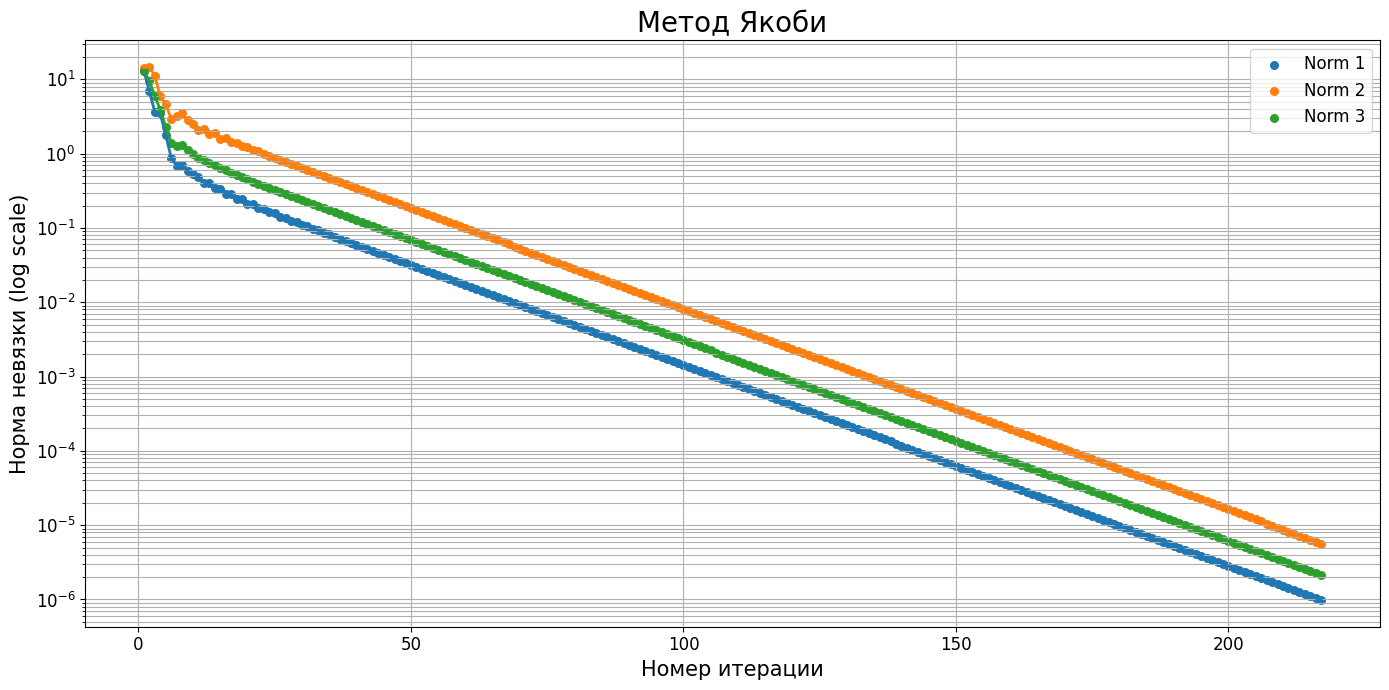

In [34]:
### Метод Якоби

def jacobi(A, f, x_0, e, n):
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []

    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        y = np.zeros(n)
        for i in range(n):
            for j in range(i):
                y[i] += A[i, j] * x[j]
            for j in range(i+1, n):
                y[i] += A[i, j] * x[j]

            y[i] = (f[i] - y[i]) / A[i, i]
        x = y

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3

x_0 = np.ones(n+1)
x_jacobi, residuals_1, residuals_2, residuals_3 = jacobi(A, f, x_0, e, n+1)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

print("Метод Якоби:")
print(f"Решение: {x_jacobi}")
for i, norm in enumerate(norms):
    residual = norm.norm(f - A.dot(x_jacobi))
    print(f"Финальная невязка в {norm.name}: {residual:.2e}")
print(f"Количество итераций: {len(residuals_1)}")

plt.figure(figsize=[14, 7])
plt.title("Метод Якоби", fontsize=20)

plt.yscale("log")

plt.xlabel('Номер итерации', fontsize=15)
plt.xticks(fontsize=12)

plt.ylabel("Норма невязки (log scale)", fontsize=15)
plt.yticks(fontsize=12)

plt.grid(which="both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name, s=30)
    plt.plot(iterations, residual, linewidth=2)

plt.legend(loc="best", fontsize=12)
plt.tight_layout()
plt.show()


### Метод Зейделя

Метод Зейделя:
Решение: [ 1.          0.06742062 -0.36515909 -0.57551717 -0.66087594 -0.66623523
 -0.61603904 -0.52502604 -0.40276215 -0.25580597]
Финальная невязка в Norm 1: 9.33e-07
Финальная невязка в Norm 2: 4.51e-06
Финальная невязка в Norm 3: 1.76e-06
Количество итераций: 54


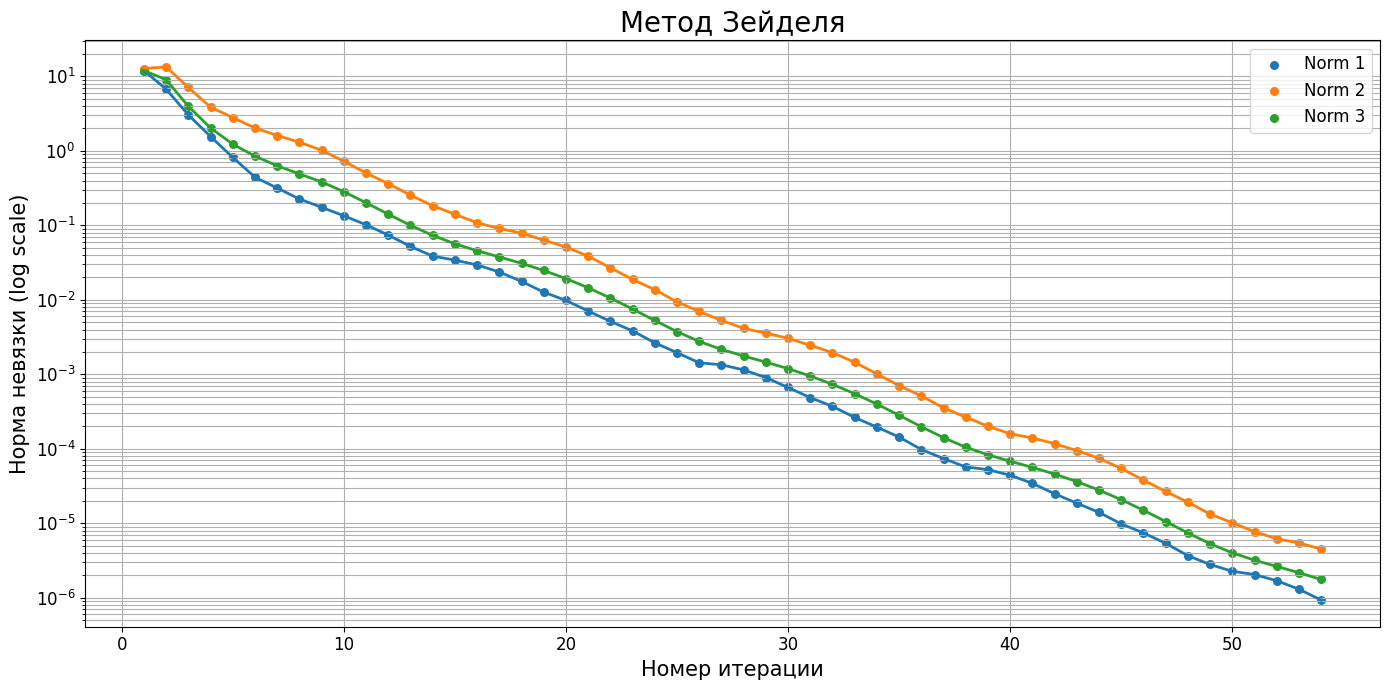

In [35]:
### Метод Зейделя

def seidel(A, f, x_0, e, n):
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []

    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        y = np.zeros(n)
        for i in range(n):
            sigma = 0.0
            for j in range(i):
                sigma += A[i, j] * y[j]
            for j in range(i+1, n):
                sigma += A[i, j] * x[j]

            y[i] = (f[i] - sigma) / A[i, i]
        x = y

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3

x_0 = np.ones(n+1)
x_seidel, residuals_1, residuals_2, residuals_3 = seidel(A, f, x_0, e, n+1)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

print("Метод Зейделя:")
print(f"Решение: {x_seidel}")
for i, norm in enumerate(norms):
    residual = norm.norm(f - A.dot(x_seidel))
    print(f"Финальная невязка в {norm.name}: {residual:.2e}")
print(f"Количество итераций: {len(residuals_1)}")

plt.figure(figsize=[14, 7])
plt.title("Метод Зейделя", fontsize=20)

plt.yscale("log")

plt.xlabel('Номер итерации', fontsize=15)
plt.xticks(fontsize=12)

plt.ylabel("Норма невязки (log scale)", fontsize=15)
plt.yticks(fontsize=12)

plt.grid(which="both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name, s=30)
    plt.plot(iterations, residual, linewidth=2)

plt.legend(loc="best", fontsize=12)
plt.tight_layout()
plt.show()


###  Метод верхней релаксации

Метод верхней релаксации (SOR):
Решение: [ 1.          0.0674204  -0.3651597  -0.57551815 -0.66087705 -0.66623604
 -0.61603913 -0.52502522 -0.40276063 -0.25580437]
Параметр релаксации ω = 1.2
Финальная невязка в Norm 1: 6.75e-07
Финальная невязка в Norm 2: 3.72e-06
Финальная невязка в Norm 3: 1.39e-06
Количество итераций: 52


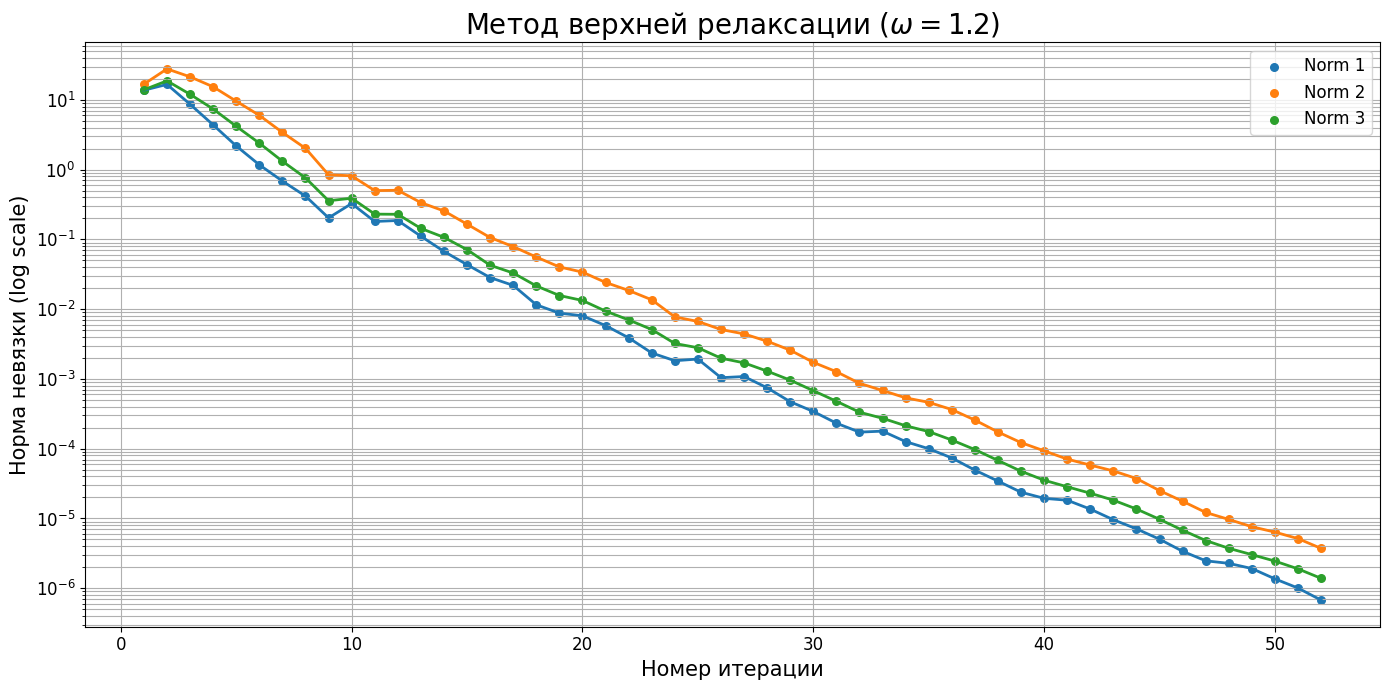

In [36]:
### Метод верхней релаксации

def SOR(A, f, x_0, w, e, n):
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []

    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        y = np.zeros(n)
        for i in range(n):
            sigma = 0.0
            for j in range(i):
                sigma += A[i, j] * y[j]
            for j in range(i+1, n):
                sigma += A[i, j] * x[j]

            sigma = (f[i] - sigma) / A[i, i]
            y[i] = x[i] + w * (sigma - x[i])
        x = y

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3

w = 1.2
x_0 = np.ones(n+1)
x_sor, residuals_1, residuals_2, residuals_3 = SOR(A, f, x_0, w, e, n+1)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

print("Метод верхней релаксации (SOR):")
print(f"Решение: {x_sor}")
print(f"Параметр релаксации ω = {w}")
for i, norm in enumerate(norms):
    residual = norm.norm(f - A.dot(x_sor))
    print(f"Финальная невязка в {norm.name}: {residual:.2e}")
print(f"Количество итераций: {len(residuals_1)}")

plt.figure(figsize=[14, 7])
plt.title(f"Метод верхней релаксации ($\\omega = {w}$)", fontsize=20)

plt.yscale("log")

plt.xlabel('Номер итерации', fontsize=15)
plt.xticks(fontsize=12)

plt.ylabel("Норма невязки (log scale)", fontsize=15)
plt.yticks(fontsize=12)

plt.grid(which="both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name, s=30)
    plt.plot(iterations, residual, linewidth=2)

plt.legend(loc="best", fontsize=12)
plt.tight_layout()
plt.show()


### Метод наискорейшего спуска

Метод наискорейшего спуска:
Решение: [ 1.00000211  0.06742946 -0.36514498 -0.57550056 -0.66086008 -0.66622402
 -0.6160361  -0.52503496 -0.40278554 -0.25584555]
Финальная невязка в Norm 1: 4.42e-06
Финальная невязка в Norm 2: 2.51e-05
Финальная невязка в Norm 3: 9.00e-06
Количество итераций: 2463


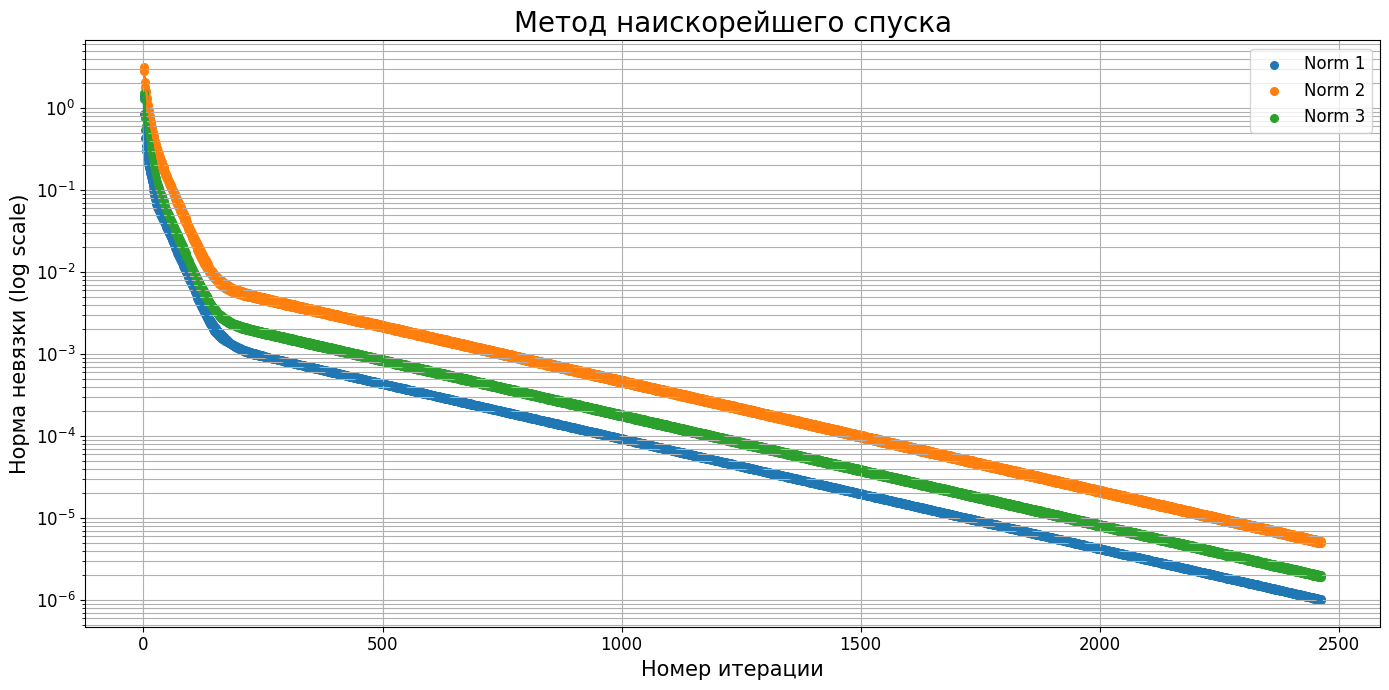

In [37]:
### Метод наискорейшего спуска

def FGD(A_, f_, x_0, e):
    A = A_.T @ A_
    f = A_.T.dot(f_)
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []

    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        tau = (A.dot(x) - f).dot(A.dot(x) - f) / (A.dot(A.dot(x) - f)).dot(A.dot(x) - f)
        x -= tau * (A.dot(x) - f)

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3


x_0 = np.ones(n+1)
x_fgd, residuals_1, residuals_2, residuals_3 = FGD(A, f, x_0, e)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

print("Метод наискорейшего спуска:")
print(f"Решение: {x_fgd}")
for i, norm in enumerate(norms):
    residual = norm.norm(f - A.dot(x_fgd))
    print(f"Финальная невязка в {norm.name}: {residual:.2e}")
print(f"Количество итераций: {len(residuals_1)}")

plt.figure(figsize=[14, 7])
plt.title("Метод наискорейшего спуска", fontsize=20)

plt.yscale("log")

plt.xlabel('Номер итерации', fontsize=15)
plt.xticks(fontsize=12)

plt.ylabel("Норма невязки (log scale)", fontsize=15)
plt.yticks(fontsize=12)

plt.grid(which="both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name, s=30)
    plt.plot(iterations, residual, linewidth=2)

plt.legend(loc="best", fontsize=12)
plt.tight_layout()
plt.show()


### Метод минимальных невязок

Метод минимальных невязок:
Решение: [ 1.00000225  0.06743015 -0.36514392 -0.57549925 -0.66085894 -0.66622319
 -0.61603602 -0.52503568 -0.4027873  -0.25584833]
Финальная невязка в Norm 1: 4.56e-06
Финальная невязка в Norm 2: 2.69e-05
Финальная невязка в Norm 3: 9.61e-06
Количество итераций: 2442


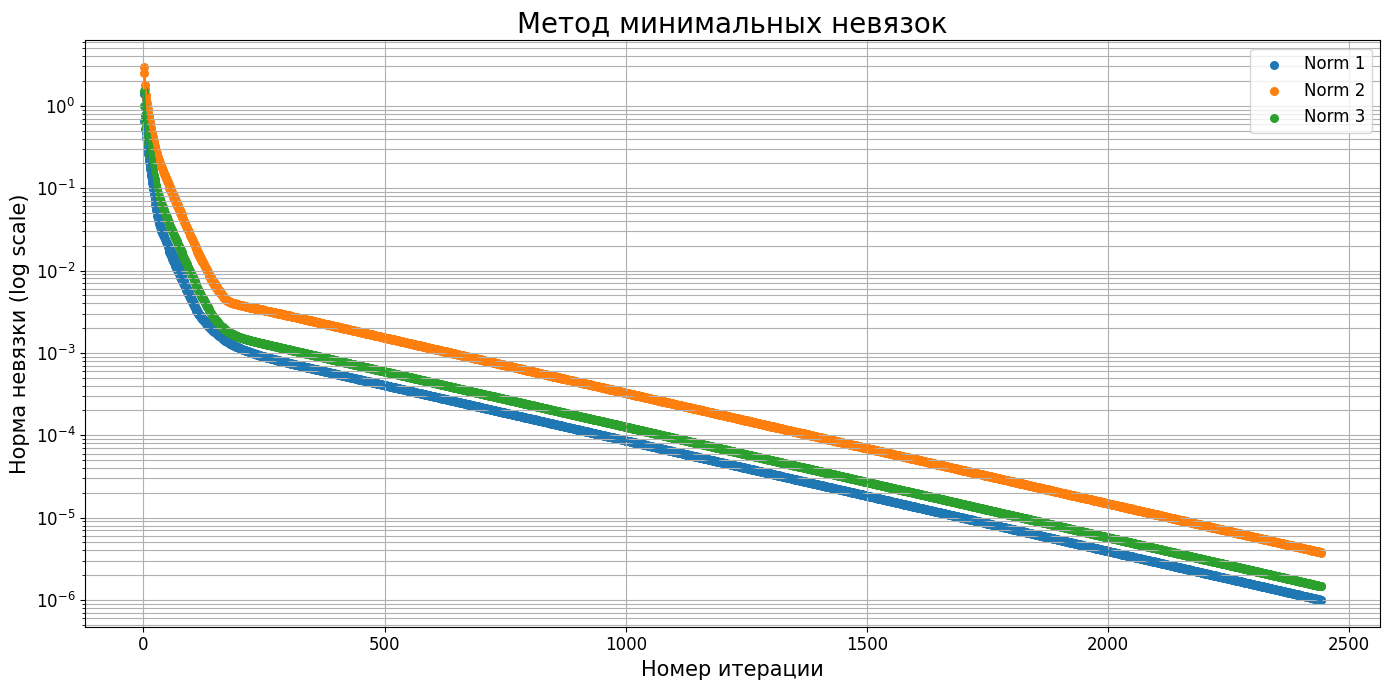

In [38]:
### Метод минимальных невязок

def MRM(A_, f_, x_0, e):
    A = A_.T @ A_
    f = A_.T.dot(f_)
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []

    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        tau = (A.dot(A.dot(x) - f)).dot(A.dot(x) - f) / (A.dot(A.dot(x) - f)).dot(A.dot(A.dot(x) - f))
        x -= tau * (A.dot(x) - f)

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3


x_0 = np.ones(n+1)
x_mrm, residuals_1, residuals_2, residuals_3 = MRM(A, f, x_0, e)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

print("Метод минимальных невязок:")
print(f"Решение: {x_mrm}")
for i, norm in enumerate(norms):
    residual = norm.norm(f - A.dot(x_mrm))
    print(f"Финальная невязка в {norm.name}: {residual:.2e}")
print(f"Количество итераций: {len(residuals_1)}")

plt.figure(figsize=[14, 7])
plt.title("Метод минимальных невязок", fontsize=20)

plt.yscale("log")

plt.xlabel('Номер итерации', fontsize=15)
plt.xticks(fontsize=12)

plt.ylabel("Норма невязки (log scale)", fontsize=15)
plt.yticks(fontsize=12)

plt.grid(which="both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name, s=30)
    plt.plot(iterations, residual, linewidth=2)

plt.legend(loc="best", fontsize=12)
plt.tight_layout()
plt.show()


### Стабилизированный метод бисопряжённых градиентов

/var/folders/7y/8_qdyw1x0570p135qdb9jgn40000gn/T/ipykernel_14142/3703014533.py:4: SparseEfficiencyWarning: spilu converted its input to CSC format
  return sparse.linalg.spilu(A)


Стабилизированный метод бисопряжённых градиентов (BiCGStab):
Решение: [ 1.          0.06741962 -0.36516076 -0.57551892 -0.66087708 -0.66623523
 -0.61603783 -0.52502411 -0.40276039 -0.2558053 ]
Финальная невязка в Norm 1: 8.88e-16
Финальная невязка в Norm 2: 2.26e-15
Финальная невязка в Norm 3: 1.09e-15
Количество итераций: 1


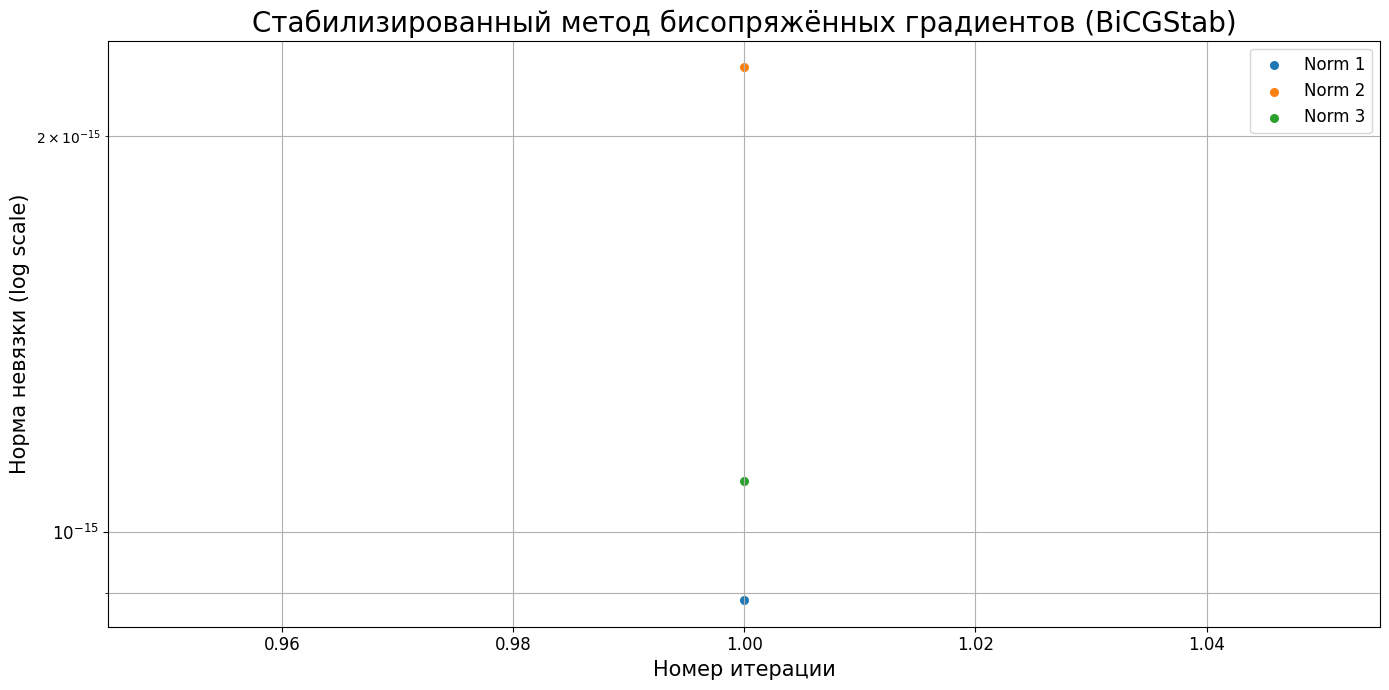

In [39]:
### Стабилизированный метод бисопряжённых градиентов

def precondition(A, n):
    return sparse.linalg.spilu(A)

def BiCGStab(A_, f_, x_0, e):
    A = A_.copy()
    f = f_.copy()
    x = x_0.copy()
    M = precondition(A, n+1)
    print(M)
    residuals_1, residuals_2, residuals_3 = [], [], []

    r_0 = f - A.dot(x)
    r = r_0
    flag = True
    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        rho = r_0.dot(r)
        if np.abs(rho) < e:
            raise RuntimeError("BiCGStab cannot solve the system")
        if flag:
            p = r
            flag = False
        else:
            beta = (rho / rho_prev) * (alpha / omega)
            p = r - beta * (p - omega * v)

        p_ = M.solve(p)
        v = A.dot(p_)
        alpha = rho / r_0.dot(v)
        s = r - alpha * v
        if norm_3(s) / norm_3(r_0) < e:
            x += alpha * p_
            residuals_1.append(norm_1(f - A.dot(x)))
            residuals_2.append(norm_2(f - A.dot(x)))
            residuals_3.append(norm_3(f - A.dot(x)))
            return x, residuals_1, residuals_2, residuals_3

        s_ = M.solve(s)
        t = A.dot(s_)
        omega = t.dot(s) / t.dot(t)
        x += alpha * p_ + omega * s_
        r = s - omega * t
        if norm_3(r) / norm_3(r_0) < e:
            residuals_1.append(norm_1(f - A.dot(x)))
            residuals_2.append(norm_2(f - A.dot(x)))
            residuals_3.append(norm_3(f - A.dot(x)))
            return x, residuals_1, residuals_2, residuals_3

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3

x_0 = np.ones(n+1)
x_bicgstab, residuals_1, residuals_2, residuals_3 = BiCGStab(A, f, x_0, e)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

print("Стабилизированный метод бисопряжённых градиентов (BiCGStab):")
print(f"Решение: {x_bicgstab}")
for i, norm in enumerate(norms):
    residual = norm.norm(f - A.dot(x_bicgstab))
    print(f"Финальная невязка в {norm.name}: {residual:.2e}")
print(f"Количество итераций: {len(residuals_1)}")

plt.figure(figsize=[14, 7])
plt.title("Стабилизированный метод бисопряжённых градиентов (BiCGStab)", fontsize=20)

plt.yscale("log")

plt.xlabel('Номер итерации', fontsize=15)
plt.xticks(fontsize=12)

plt.ylabel("Норма невязки (log scale)", fontsize=15)
plt.yticks(fontsize=12)

plt.grid(which="both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name, s=30)
    plt.plot(iterations, residual, linewidth=2)

plt.legend(loc="best", fontsize=12)
plt.tight_layout()
plt.show()
